# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools

In [2]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):
v_theta = (np.pi/2)-np.radians(-7.145) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(167.78) # Right Ascension E[0,2pi]

In [3]:
# unit vector in R3. 
# Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function retuns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Ploting random stars in the Sky

In [5]:
np.random.seed(7)
n_stars = 100
npair = n_stars*(n_stars -1)/2
theta = np.arccos(np.random.uniform(-1,1,n_stars))
phi = np.random.uniform(0,2*np.pi,n_stars)
#theta = np.random.uniform(0.1, np.pi, n_stars)  # colatitude E[0, pi]
#phi = np.random.uniform(0.1, 2*np.pi, n_stars) # longitude [0, 2pi]

n1=np.array(skyvec(theta, phi)).T#.reshape(n_stars,3)
n2=np.array(skyvec(theta, phi)).T#.reshape(n_stars,3)
#n1[7]

#print(n1)
#print(n2[1])
print(n2)
#print(n1)
print(np.dot(n1[2],n1[2]))
np.dot(n1[1],n1[1])

[[ 4.81503544e-01  2.23820631e-01 -8.47383421e-01]
 [-5.16331070e-01  6.48061807e-01  5.59837584e-01]
 [ 3.81666597e-01 -9.16055084e-01 -1.23181537e-01]
 [-8.03853253e-01  3.92521599e-01  4.46930356e-01]
 [-2.37551558e-01 -1.72259580e-01  9.55979024e-01]
 [-1.36380495e-01 -9.87660181e-01  7.69917408e-02]
 [ 4.32744664e-01 -9.01513746e-01  2.24092732e-03]
 [ 3.41421235e-02 -5.16016846e-01 -8.55897733e-01]
 [ 8.85401976e-01  3.97657794e-02 -4.63122040e-01]
 [-8.77082937e-01  4.80338909e-01 -2.34998349e-04]
 [-9.08615086e-01  2.14301328e-01  3.58459992e-01]
 [ 7.46527734e-01  2.71416164e-01  6.07478072e-01]
 [-9.38495926e-01 -2.50050677e-01 -2.38117734e-01]
 [-3.86831580e-01 -3.10992459e-01 -8.68127306e-01]
 [ 4.28636832e-01 -7.97960725e-01 -4.23708801e-01]
 [ 5.35616992e-01 -2.05053665e-01  8.19187055e-01]
 [ 5.67827502e-01  5.90745382e-01 -5.73229293e-01]
 [ 1.22084567e-01  9.87890125e-01 -9.57520764e-02]
 [-2.73495537e-01 -4.25964395e-01  8.62412039e-01]
 [ 2.09772625e-01  2.30461428e-

1.0000000000000002

In [6]:
# Note that alpha and gamma give scalars as result.

def hola(y):
    if y==0:
        hola=0
    else:
        hola= y*np.log(y)
    #if y<0:
    #    hola= y*np.log(np.abs(y))
    return hola
#print(hola(-5))

def alpha(v,n1,n2):
    cos_zeta = np.dot(n1,n2)
    y = (1- cos_zeta)/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(1/2- np.dot(n1,n2)/2))
    den = 6*n1v*(y-1)**3
    return num/den

def gamma(v,n1,n2):
    y = (1-np.dot(n1,n2))/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 3*n1v*((y-1)**2)
    return num/den

I_3 = np.eye(3)
def delta_ij(i, j):
    return 1 if i == j else 0

def GTanalytic_Hij_1(v, n1, n2):
    y = (1-np.dot(n1,n2))/2 # change to zeta if phi is not 0.
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    alph = alpha(v,n1,n2)
    gamm = gamma(v,n1,n2)
    t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
    t2 = np.outer(n1, n1)*( alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(n1, n2)+np.outer(n2, n1))
    t3 = np.outer(n2, n2)*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(n1, v) + 2*gamm*np.outer(n2, v)
    return t1+t2+t3 #alpha*coeff_alpha/(2*y-1) + 2*beta*coeff_beta

## Changing the color of the map according to a function

In [26]:
nside = 32
npix = hp.nside2npix(nside)

#frame velocity 
vtheta, vphi = hp.pix2ang(nside, np.arange(npix))
vdir = skyvec(vtheta,vphi)#.reshape(npix,3) #np.column_stack(skyvec(vtheta,vphi))

#stheta, sphi = hp.pix2ang(nside, np.arange(npix))
#n1_pix = skyvec(stheta,sphi).T#.reshape(npix,3)

#vdir[3000]
print(vdir.T[6000:6020])
print(npix)
#print(np.outer(vdir[200],n1[1]))
#print(np.outer(vdir[200],n1[1])[2,1])

# Defined to save the results
#Hij_1 = np.zeros(npix)
#print(Hij_1)

[[-7.06953313e-01  7.06953313e-01  2.08333333e-02]
 [-7.40790311e-01  6.71413201e-01  2.08333333e-02]
 [-7.72842681e-01  6.34255597e-01  2.08333333e-02]
 [-8.03033205e-01  5.95570015e-01  2.08333333e-02]
 [-8.31289152e-01  5.55449653e-01  2.08333333e-02]
 [-8.57542451e-01  5.13991165e-01  2.08333333e-02]
 [-8.81729854e-01  4.71294426e-01  2.08333333e-02]
 [-9.03793094e-01  4.27462298e-01  2.08333333e-02]
 [-9.23679016e-01  3.82600376e-01  2.08333333e-02]
 [-9.41339715e-01  3.36816736e-01  2.08333333e-02]
 [-9.56732644e-01  2.90221675e-01  2.08333333e-02]
 [-9.69820720e-01  2.42927444e-01  2.08333333e-02]
 [-9.80572413e-01  1.95047980e-01  2.08333333e-02]
 [-9.88961822e-01  1.46698628e-01  2.08333333e-02]
 [-9.94968734e-01  9.79958669e-02  2.08333333e-02]
 [-9.98578680e-01  4.90570248e-02  2.08333333e-02]
 [-9.99782963e-01  1.22438100e-16  2.08333333e-02]
 [-9.98578680e-01 -4.90570248e-02  2.08333333e-02]
 [-9.94968734e-01 -9.79958669e-02  2.08333333e-02]
 [-9.88961822e-01 -1.46698628e-

In [27]:
H1_00 = np.zeros(npix)

#for k in range(npix):
    #for i in range(3):
        #for j in range(3):
for strpair in itertools.combinations(np.arange(n_stars),2):
                idx_p,idx_q = strpair
                I_3= delta_ij(0, 0)
                v= vdir #skyvec(v_theta,v_phi) #vdir#[k]
                p= n1[idx_p]
                q= n2[idx_q]
                y = (1-np.dot(p,q))/2
                n1v = np.dot(p,v)
                n2v = np.dot(q,v)
                alph = alpha(v,p,q)
                gamm = gamma(v,p,q)
                t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
                t2 = np.outer(p, p)[0,0]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[0,0]+np.outer(q, p)[0,0])
                t3 = np.outer(q, q)[0,0]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[0,0] + 2*gamm*np.outer(q, v)[0,0]
                GT = t1+t2+t3
                H1_00+= GT

In [123]:
H1_11 = np.zeros(npix)

#for k in range(npix):
    #for i in range(3):
        #for j in range(3):
for strpair in itertools.combinations(np.arange(n_stars),2):
                idx_p,idx_q = strpair
                I_3= delta_ij(1, 1)
                v= vdir#[k]#skyvec(v_theta,v_phi) #
                p= n1[idx_p]
                q= n2[idx_q]
                y = (1-np.dot(p,q))/2
                n1v = np.dot(p,v)
                n2v = np.dot(q,v)
                alph = alpha(v,p,q)
                gamm = gamma(v,p,q)
                t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
                t2 = np.outer(p, p)[1,1]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[1,1]+np.outer(q, p)[1,1])
                t3 = np.outer(q, q)[1,1]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[1,1] + 2*gamm*np.outer(q, v)[1,1]
                GT = t1+t2+t3
                H1_11+= GT

In [124]:
H1_22 = np.zeros(npix)

for strpair in itertools.combinations(np.arange(n_stars),2):
                idx_p,idx_q = strpair
                I_3= delta_ij(2, 2)
                v= vdir#[k]skyvec(v_theta,v_phi) #vdir#[k]
                p= n1[idx_p]
                q= n2[idx_q]
                y = (1-np.dot(p,q))/2
                n1v = np.dot(p,v)
                n2v = np.dot(q,v)
                alph = alpha(v,p,q)
                gamm = gamma(v,p,q)
                t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
                t2 = np.outer(p, p)[2,2]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[2,2]+np.outer(q, p)[2,2])
                t3 = np.outer(q, q)[2,2]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[2,2] + 2*gamm*np.outer(q, v)[2,2]
                GT = t1+t2+t3
                H1_22+= GT

In [125]:
print(H1_00)
#H1_ij.shape

H1_jj= H1_00 + H1_11 + H1_22
print(H1_jj)

[ 418.17370286  111.62307594 -146.93890204 ...   95.7587406  -423.10243441
 -115.37209069]
[ 2460.81063868   184.21513682 -1224.17039865 ...   536.03620499
 -2380.58491601  -182.25883909]


Number of stars: 100
Number of pairs: 4950.0
Number of pixels: 12288


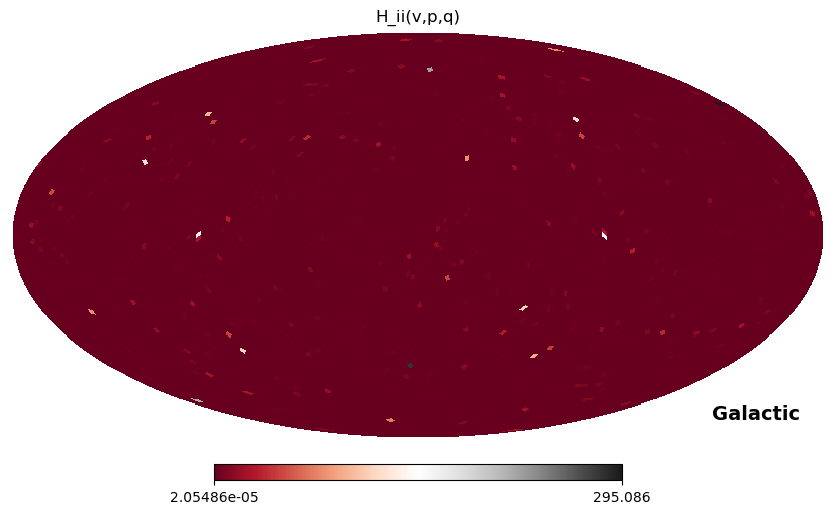

In [137]:
#m = np.arange(len(resultsH0))
print('Number of stars:',n_stars)
print('Number of pairs:',npair)
print('Number of pixels:',npix)
hp.mollview(abs(H1_jj)/npair,title='H_ii(v,p,q)', cmap='RdGy', coord=['E','G'])

In [12]:
# Defined to save the results
Hij_1f = np.zeros(npix)

for k in range(npix):
    for m in range(n_stars):
        for n in range(n_stars):
            for i in range(3):
                for j in range(3):
                    I_3= delta_ij(i, j)
                    v= vdir[k]
                    p= n1[m]
                    q= n2[n]
                    y = (1-np.dot(p,q))/2
                    n1v = np.dot(p,v)
                    n2v = np.dot(q,v)
                    alph = alpha(v,p,q)
                    gamm = gamma(v,p,q)
                    t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
                    t2 = np.outer(p, p)[i,j]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[i,j]+np.outer(q, p)[i,j])
                    t3 = np.outer(q, q)[i,j]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[i,j] + 2*gamm*np.outer(q, v)[i,j]
                    Hij_1f += t1+t2+t3

ValueError: shapes (3,) and (12288,) not aligned: 3 (dim 0) != 12288 (dim 0)

In [ ]:
print(Hij_1f)

In [ ]:
H12_1 = np.zeros(npix)

for k in range(npix):
    #for strpair in itertools.combinations(np.arange(n_stars),2):
    for l in range(n_stars):
        #idx_p,idx_q = strpair
        I_3= delta_ij(1, 2)
        v= vdir[k]
        p= [2,5,1] #n1[idx_p]
        q= n2[l] #[1,3,4] #
        y = (1-np.dot(p,q))/2
        n1v = np.dot(p,v)
        n2v = np.dot(q,v)
        alph = alpha(v,p,q)
        gamm = gamma(v,p,q)
        t1 = I_3 * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
        t2 = np.outer(p, p)[1,2]*(alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[1,2]+np.outer(q, p)[1,2])
        t3 = np.outer(q, q)[1,2]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[1,2] + 2*gamm*np.outer(q, v)[1,2]
        H12_1+= t1+t2+t3